In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
from collections import Counter
import joblib
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
pp = pprint.PrettyPrinter(indent=4)
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
from PIL import Image

In [2]:

def write_pkl(img_data, pklname):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    img_data: str
        CSV file with image and category data
    pklname: str
        path to output file

    """
     
    data = dict()
    data['description'] = 'product images in rgb'
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    df = pd.read_csv(img_data)
    for idx, row in df.iterrows():
        # create smaller data set to see if memory issues
        # if idx > 6302:
        #     break
        img_file = f"./images_clean/{row['img_file_name']}"

        if img_file[-3:] in {'jpg', 'png'}:
            im = imread(img_file)
            im = resize(im, (80, 80)) #[:,:,::-1]
            data['label'].append(row['category_id'])
            data['filename'].append(row['img_file_name'])
            data['data'].append(im)
 
    joblib.dump(data, pklname)

In [3]:
write_pkl('image_cat.csv', 'image_cat2')

In [4]:
data = joblib.load(f'image_cat2.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  12604
keys:  ['description', 'label', 'filename', 'data']
description:  product images in rgb
image shape:  (80, 80, 3)
labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


Counter({6: 1471,
         1: 691,
         4: 938,
         7: 1033,
         10: 786,
         2: 771,
         9: 908,
         5: 1088,
         11: 860,
         0: 917,
         3: 1136,
         8: 1177,
         12: 828})

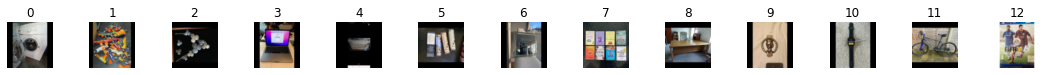

In [5]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [4]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

data = joblib.load(f'image_cat2.pkl')



In [6]:

X = np.array(data['data'])
y = np.array(data['label'])

In [7]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3
)

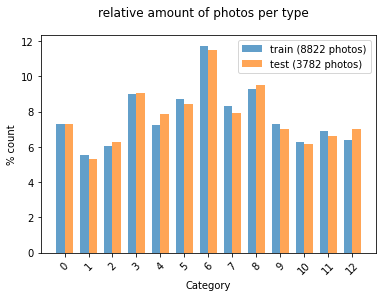

In [8]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('Category')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

In [9]:

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [10]:
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(8822, 576)


In [11]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [12]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [13]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[False False  True False False False False False False False False False
 False False  True False False False False  True  True False False False
 False]

Percentage correct:  17.21311475409836


In [14]:
from sklearn.metrics import confusion_matrix
 
cmx = confusion_matrix(y_test, y_pred)
cmx

array([[ 50,   9,  13,  32,  14,  15,  39,  11,  49,  13,  13,  10,   7],
       [  7,  24,  35,   9,  10,  14,  27,  14,  18,  13,  14,   6,  10],
       [  9,  20,  38,  17,  15,  19,  32,  22,  20,  20,   9,   8,   9],
       [ 33,  12,  12, 119,  17,  25,  32,  13,  27,  15,  13,  13,  11],
       [ 23,   9,  24,  35,  23,  18,  48,  30,  30,  11,  13,  17,  16],
       [ 18,  26,  17,  38,  18,  28,  51,  27,  34,  20,  13,  13,  17],
       [ 38,  26,  24,  59,  29,  24,  82,  21,  60,  23,  16,  15,  18],
       [  9,  13,  12,  32,  20,  21,  33,  76,  20,  25,  18,   8,  13],
       [ 40,  11,  19,  58,  26,  23,  58,  15,  66,  13,  10,   7,  13],
       [ 16,  11,  11,  32,  19,  27,  34,  25,  29,  26,   9,  19,   8],
       [ 15,  11,   8,  28,  10,  20,  16,  16,  24,  16,  55,   3,  12],
       [ 10,  15,  15,  13,  28,  14,  46,  16,   8,   8,  17,  40,  20],
       [ 18,  16,   6,  36,  18,  15,  26,  41,  13,  18,  25,   9,  24]])


 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


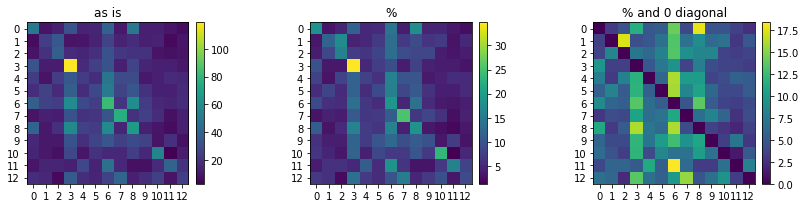

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

In [18]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))


Percentage correct:  17.21311475409836


In [19]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

In [20]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


: 

: 